<a href="https://colab.research.google.com/github/Sompote/RIC_predict/blob/main/transformer_RIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This code is for a transformer for predict RIC results combindnation of LSTM and CON1D together to predict RIC
*   The feature was add to encoding data
*   initial qc value is in [:,:,0]




In [83]:
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/Data_RIC.xlsx')
data=np.array(df)
X=data[:,1:28]
Y=data[:,34:61]
x_feature=data[:,28:31]




In [84]:
def movingavarage(array,window):
  X = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window)/window, mode='valid'), axis=1, arr=array)
  return X
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(X_feature)

X_train_smooth=movingavarage(x_train,8)
Y_train_smooth=movingavarage(y_train,8)


In [85]:
#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test = train_test_split(x_train, x_feature, y_train, test_size=0.01)

#_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [86]:
X_test.shape

(1, 27, 1)

In [87]:
#Model generation part
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
#from attention import Attention





def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  cnn_output = Conv1D(filters=64, kernel_size=4, activation='relu',name='CNN_layer')(cnn_input)
  cnn_output = Conv1D(filters=64, kernel_size=4, activation='relu')(cnn_output)
  #cnn_output = Attention(units=32)(cnn_output)

  cnn_output = Flatten()(cnn_output)
  cnn_output = Dense(50, activation='linear')(cnn_output)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  return cnn_model


def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='LSTM_input')
  dense_output = LSTM(20,return_sequences=True)(dense_input)
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(dense_output)

  dense_output = Dense(200, activation='sigmoid')(layer)
  layer=Dropout(0.2)(layer)
  dense_output = Dense(50, activation='linear')(layer)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def encoding_model(LSTM_model,cnn_model,latent_dim):
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dropout(0.2)(layer)
  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output,name='encoding_model')
  return combined_model

def decoding_model1(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  dense_output = Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  dense_output = Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dropout(0.2)
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dense(100, activation='tanh')(layer)
  layer=Dense(time_step, activation='tanh')(layer)
  layer=Reshape((time_step,1))(layer)
  LSTM_out =  LSTM(1,return_sequences=True)(layer)
  output=LSTM_out[:,:,0]


  #dense_output = Dense(time_step, activation='linear')(layer)

  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def decoding_model(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  inputs_f = Input(shape=feature_dim, name='feature')
  layerf_int=  Dense(40, activation='sigmoid')(inputs_f)
  layerfeature=  Dense(latent_dim, activation='sigmoid')(layerf_int)
  combined_input = concatenate([inputs_l, layerfeature],name='combind_feature')
  layer=Dropout(0.2)(combined_input)
  layer=Dense(200, activation='sigmoid')(layer)
  layer=Dense(100, activation='relu')(layer)
  dense_output = Dense(time_step, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,inputs_f], outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):
  input_f = Input(shape=feature_dim, name='feature')
  #inputs_feature=Dense(feature_dim, activation='sigmoid')
  #inputs_f = decoding_model.input[1]
  input_l=encoding_model.output
  print(input_l)
  outputs = decoding_model([input_l,input_f])
  print(outputs)
  model = Model(inputs=[input_f,encoding_model.input], outputs=outputs)
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=15
time_step=Y_train.shape[1]
model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)

#model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_encoding=encoding_model(model_lstm,model_cnn,latent_dim)
model_decoding=decoding_model(latent_dim,feature_dim,time_step)
model_transform=transformer(model_encoding,model_decoding,feature_dim)
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=6,restore_best_weights=True)

history=model_transform.fit([X_feature_train,X_train, X_train], Y_train, epochs=2000, batch_size=6,validation_data=([X_feature_test,X_test,X_test], Y_test))

KerasTensor(type_spec=TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), name='dense_243/BiasAdd:0', description="created by layer 'dense_243'")
KerasTensor(type_spec=TensorSpec(shape=(None, 27), dtype=tf.float32, name=None), name='decoding_model/dense_248/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 27, 1)]      0           []                               
                                                                                                  
 CNN_input (InputLayer)         [(None, 27, 1)]      0           []                               
                                                                                                  
 lstm_30 (LSTM)                 (None, 27, 20)       1760     

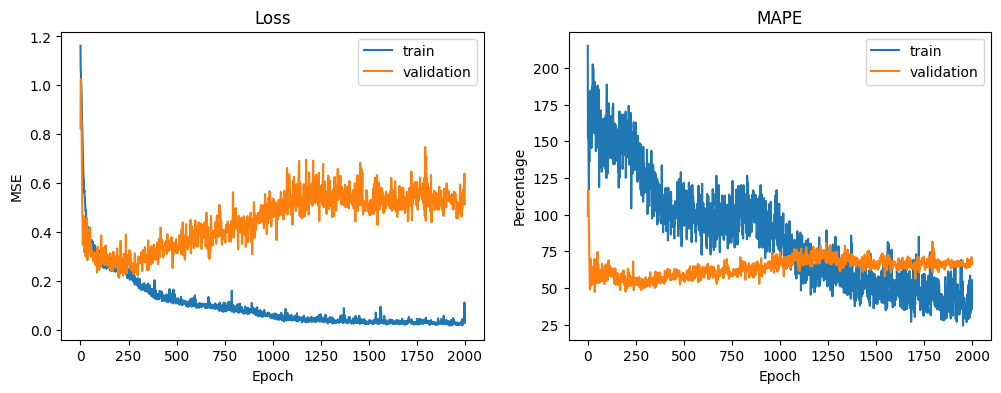

In [88]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 LSTM_input (InputLayer)        [(None, 27, 1)]      0           []                               
                                                                                                  
 CNN_input (InputLayer)         [(None, 27, 1)]      0           []                               
                                                                                                  
 lstm_30 (LSTM)                 (None, 27, 20)       1760        ['LSTM_input[0][0]']             
                                                                                                  
 CNN_layer (Conv1D)             (None, 24, 64)       320         ['CNN_input[0][0]']              
                                                                                           

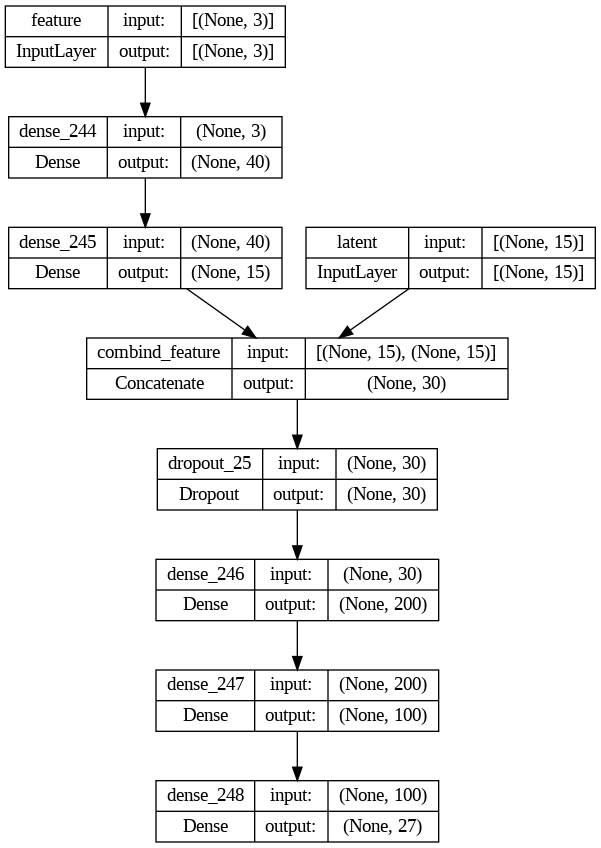

In [89]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model2.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)
img_file = 'model.png'
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)

In [100]:
#validation
x_predictn=np.zeros((1,27))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[8,1:28]
X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=100 #blow
x_feature[0,1]=30 #fine
x_feature[0,2]=5 #thickness
X_feature = sc_f.transform(x_feature)
#set up calculation matrix
x_cal=np.zeros((1,27,1))
x_cal[:,:,0]=X_predict
y=model_transform.predict([X_feature,x_cal,x_cal])
y=sc_y.inverse_transform(y)
print(y)
#plot


1/1 [==============================] - 0s 134ms/step
[[ 0.644946   -0.28399947  0.9071673   8.418029   19.82678    27.797655
  32.3743     33.683624   35.485504   29.521456   10.589157    1.0137053
   0.97418594  1.1946853   1.4886011   1.8280487   0.67919266  1.7561004
   2.9961395   1.6752088   3.0966291   2.2321506   1.6999657   1.8535933
   3.4618187   4.397769    7.2971554 ]]


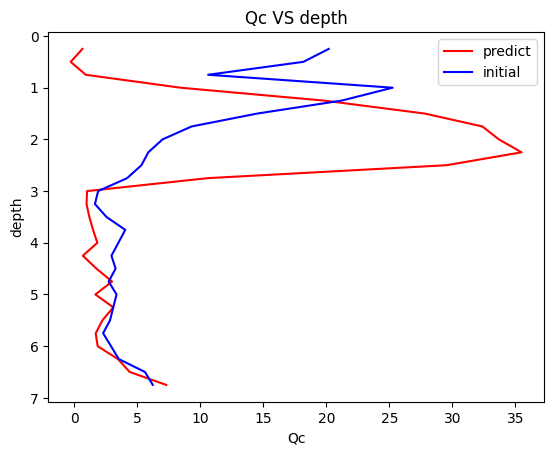

In [101]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()